In [1]:
import src.merge_utils.merge_fb as fmerge
import torch 
from matplotlib import pyplot as plt
import pandas as pd

import numpy as np
import  random
random.seed = 42

import torch

from pathlib import Path
# import plotly.graph_objects as go
import plotly.express as px
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

/var/folders/yn/vsg2jym17n53j3rtc1ncvd7r0000gn/T/ipykernel_16384/2555115472.py:4: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


# Preliminary: show how our compression works on image data

Using image data, the original source of our merging strategy, show how we can use this technique on 2d images.  We then will show how this can be ported over to the 3d domain

In [2]:
square_shape = 4
rands = torch.rand((1,square_shape**2,3))
rands.shape

torch.Size([1, 16, 3])

In [3]:
merge_func, unmerge_func = fmerge.bipartite_soft_matching(rands, 3)


In [4]:
compressed = unmerge_func(merge_func(rands))
masked = torch.where(compressed != rands,compressed, 1)

print("Show shape before and after merging")
compressed.shape, merge_func(rands).shape

Show shape before and after merging


(torch.Size([1, 16, 3]), torch.Size([1, 13, 3]))

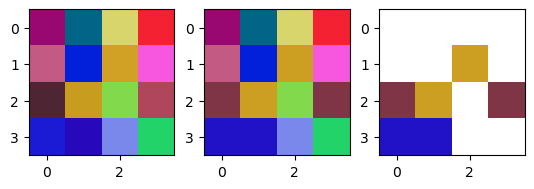

In [5]:
plt.subplot(131)
plt.imshow(torch.reshape(rands,(square_shape,square_shape,-1)))
plt.subplot(132)
plt.imshow(torch.reshape(compressed,(square_shape,square_shape,-1)))
plt.subplot(133)
plt.imshow(torch.reshape( masked,(square_shape,square_shape,-1)))


# Now port that same strategy over to 3d pointclouds 

For now, we will just be using the explicit 3d coordinates of the pointcloud as inputs. Eventually, we will running this on latent states of each point / cluster, as done by the facebok paper. 



## First, attempt with a random point cloud 
   

In [6]:
def pcshowmulti(pointsize=7,**kwargs):
    pclouds = []
    for name,data in kwargs.items() :
        df = pd.DataFrame(data,columns=['x','y','z'])
        df['type'] = name 
        pclouds.append(df)
    df = pd.concat(pclouds)
    fig = px.scatter_3d(df, x='x', y='y', z='z',
              symbol='type',color='type', opacity=0.7)

    # tight layout
    fig.update_layout(margin=dict(l=0, r=0, b=0, t=0))
    fig.update_traces(marker=dict(size=pointsize))
    fig.show()

In [7]:
pointcloud = torch.rand((1,10,3))
pmerger, punmerger = fmerge.bipartite_soft_matching(pointcloud,5)
merged = pmerger(pointcloud)
compressed = punmerger(pmerger(pointcloud))
print(pointcloud.shape, merged.shape, compressed.shape)

torch.Size([1, 10, 3]) torch.Size([1, 5, 3]) torch.Size([1, 10, 3])


In [8]:
pcshowmulti(pointcloud =pointcloud[0], merged = merged[0], compressed = compressed[0],pointsize=7)

## Now repeat the process with an actual point cloud taken from modelnet

In [9]:
path = Path("./data/modelnet40")

def read_off(file):
    off_header = file.readline().strip()
    if 'OFF' == off_header:
        n_verts, n_faces, __ = tuple([int(s) for s in file.readline().strip().split(' ')])
    else:
        n_verts, n_faces, __ = tuple([int(s) for s in off_header[3:].split(' ')])
    verts = [[float(s) for s in file.readline().strip().split(' ')] for i_vert in range(n_verts)]
    faces = [[int(s) for s in file.readline().strip().split(' ')][1:] for i_face in range(n_faces)]
    return verts, faces

with open(path/"car/train/car_0012.off", 'r') as f:
    verts, faces = read_off(f)

class PointSampler(object):
    def __init__(self, output_size):
        assert isinstance(output_size, int)
        self.output_size = output_size
    
    def triangle_area(self, pt1, pt2, pt3):
        side_a = np.linalg.norm(pt1 - pt2)
        side_b = np.linalg.norm(pt2 - pt3)
        side_c = np.linalg.norm(pt3 - pt1)
        s = 0.5 * ( side_a + side_b + side_c)
        return max(s * (s - side_a) * (s - side_b) * (s - side_c), 0)**0.5

    def sample_point(self, pt1, pt2, pt3):
        # barycentric coordinates on a triangle
        # https://mathworld.wolfram.com/BarycentricCoordinates.html
        s, t = sorted([random.random(), random.random()])
        f = lambda i: s * pt1[i] + (t-s)*pt2[i] + (1-t)*pt3[i]
        return (f(0), f(1), f(2))
        
    
    def __call__(self, mesh):
        verts, faces = mesh
        verts = np.array(verts)
        areas = np.zeros((len(faces)))

        for i in range(len(areas)):
            areas[i] = (self.triangle_area(verts[faces[i][0]],
                                           verts[faces[i][1]],
                                           verts[faces[i][2]]))
            
        sampled_faces = (random.choices(faces, 
                                      weights=areas,
                                      cum_weights=None,
                                      k=self.output_size))
        
        sampled_points = np.zeros((self.output_size, 3))

        for i in range(len(sampled_faces)):
            sampled_points[i] = (self.sample_point(verts[sampled_faces[i][0]],
                                                   verts[sampled_faces[i][1]],
                                                   verts[sampled_faces[i][2]]))
        
        return sampled_points
    
class Normalize(object):
    def __call__(self, pointcloud):
        assert len(pointcloud.shape)==2
        
        norm_pointcloud = pointcloud - np.mean(pointcloud, axis=0) 
        norm_pointcloud /= np.max(np.linalg.norm(norm_pointcloud, axis=1))

        return  norm_pointcloud


In [10]:

n_sample = 600
k_subsample =  0.4

pointcloud = PointSampler(n_sample)((verts, faces))

norm_pointcloud = torch.from_numpy(Normalize()(pointcloud)).unsqueeze(0)
print(norm_pointcloud.shape)

pmerger, punmerger = fmerge.bipartite_soft_matching(norm_pointcloud,int(n_sample*k_subsample))
pc_merged = pmerger(norm_pointcloud)
pc_compressed = punmerger(pmerger(norm_pointcloud))

pointsize = 4

# pcshow(*norm_pointcloud[0].T, pointsize=pointsize)
# pcshow(*merged[0].T, pointsize=pointsize)
# pcshow(*compressed[0].T, pointsize=pointsize)
pcshowmulti(pointcloud =norm_pointcloud[0], merged = pc_merged[0], compressed = pc_compressed[0],pointsize=4)

torch.Size([1, 600, 3])
